In [56]:
pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 1.4 MB/s  0:00:06 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
train_path = "/Users/pranjalsharma/Downloads/sales-forecasting/archive/train.csv"
test_path  = "/Users/pranjalsharma/Downloads/sales-forecasting/archive/test.csv"
store_path = "/Users/pranjalsharma/Downloads/sales-forecasting/archive/store.csv"


In [3]:
train = pd.read_csv(train_path)


/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/3098077256.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(train_path)


In [4]:
test  = pd.read_csv(test_path)


In [5]:
store = pd.read_csv(store_path)

In [7]:
print(train.shape, test.shape, store.shape)
train.head()

(1017209, 9) (41088, 8) (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Extracting Time Features

In [8]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date']  = pd.to_datetime(test['Date'])


In [9]:
for df in [train, test]:
    df['Year']  = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day']   = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek

In [10]:
df = train.merge(store, on='Store', how='left')
print(df.shape)
df.head()

(1017209, 21)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4,2015-07-31,6064,625,1,1,0,1,2015,...,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,4,2015-07-31,8314,821,1,1,0,1,2015,...,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,4,2015-07-31,13995,1498,1,1,0,1,2015,...,31,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4,2015-07-31,4822,559,1,1,0,1,2015,...,31,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
df.isnull().sum().sort_values(ascending=False)


PromoInterval                508031
Promo2SinceYear              508031
Promo2SinceWeek              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
Day                               0
Promo2                            0
Assortment                        0
StoreType                         0
Store                             0
DayOfWeek                         0
Year                              0
SchoolHoliday                     0
StateHoliday                      0
Promo                             0
Open                              0
Customers                         0
Sales                             0
Date                              0
Month                             0
dtype: int64

In [12]:
# CompetitionDistance: replace NaN with median
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)

# CompetitionOpenSince* → fill with mode or backfill
df['CompetitionOpenSinceYear'].fillna(df['Year'], inplace=True)
df['CompetitionOpenSinceMonth'].fillna(df['Month'], inplace=True)

# Promo2-related
df['Promo2SinceYear'].fillna(0, inplace=True)
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['PromoInterval'].fillna('None', inplace=True)


/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/4209162034.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/4209162034.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

In [13]:
# Convert to category dtype
cat_cols = ['StoreType', 'Assortment', 'PromoInterval']
for col in cat_cols:
    df[col] = df[col].astype('category')

# One-hot encode
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [14]:
# Weekend / weekday flag
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# Competition active flag
df['CompetitionOpen'] = (
    12 * (df['Year'] - df['CompetitionOpenSinceYear']) +
    (df['Month'] - df['CompetitionOpenSinceMonth'])
)
df['CompetitionOpen'] = df['CompetitionOpen'].apply(lambda x: 1 if x > 0 else 0)

# Promo ongoing flag
df['IsPromo'] = df['Promo'].astype(int)


In [15]:
print(df.describe())
print(df.info())

# Total unique stores
print("Number of stores:", df['Store'].nunique())


              Store     DayOfWeek                           Date  \
count  1.017209e+06  1.017209e+06                        1017209   
mean   5.584297e+02  2.998341e+00  2014-04-11 01:30:42.846061824   
min    1.000000e+00  0.000000e+00            2013-01-01 00:00:00   
25%    2.800000e+02  1.000000e+00            2013-08-17 00:00:00   
50%    5.580000e+02  3.000000e+00            2014-04-02 00:00:00   
75%    8.380000e+02  5.000000e+00            2014-12-12 00:00:00   
max    1.115000e+03  6.000000e+00            2015-07-31 00:00:00   
std    3.219087e+02  1.997391e+00                            NaN   

              Sales     Customers          Open         Promo  SchoolHoliday  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   1.017209e+06   
mean   5.773819e+03  6.331459e+02  8.301067e-01  3.815145e-01   1.786467e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    3.727000e+03  4.050000e+02  1.000000e+00  0.000000e+00   0.0

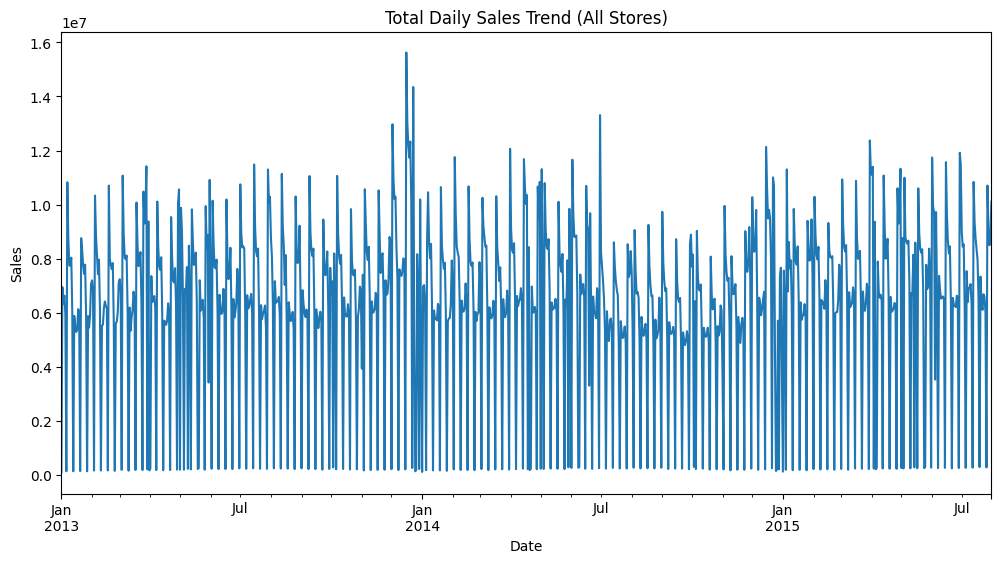

In [16]:
daily_sales = df.groupby('Date')['Sales'].sum()

plt.figure(figsize=(12,6))
daily_sales.plot()
plt.title('Total Daily Sales Trend (All Stores)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


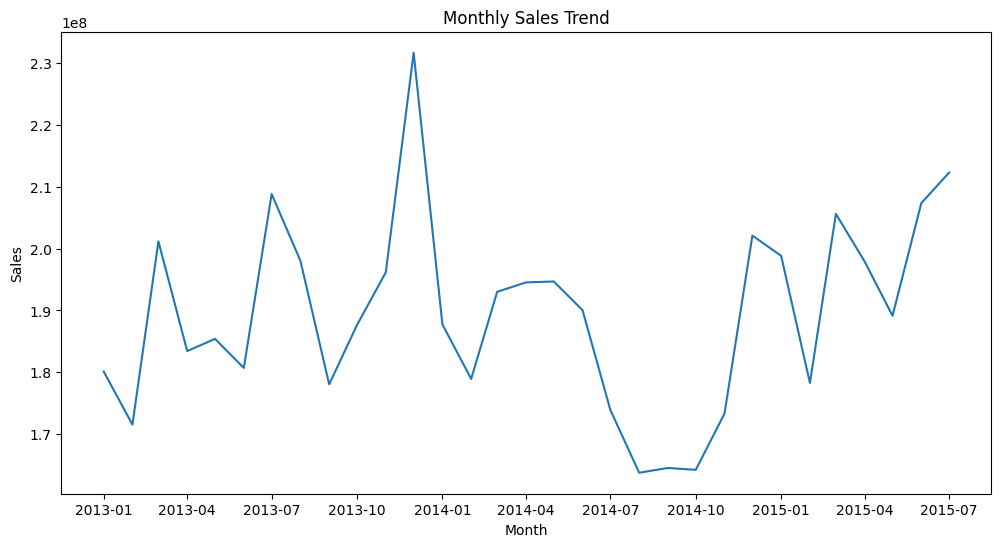

In [17]:
monthly_sales = df.groupby(['Year','Month'])['Sales'].sum().reset_index()
monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales[['Year','Month']].assign(DAY=1))

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Sales'])
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()


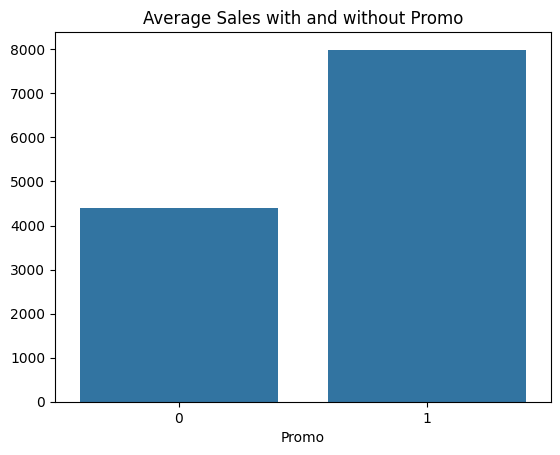

In [18]:
promo_effect = df.groupby('Promo')['Sales'].mean()
sns.barplot(x=promo_effect.index, y=promo_effect.values)
plt.title('Average Sales with and without Promo')
plt.show()


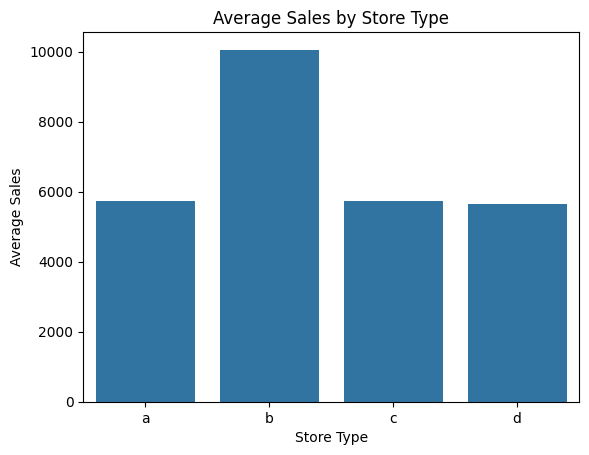

In [19]:
avg_sales_type = train.merge(store, on='Store', how='left').groupby('StoreType')['Sales'].mean()
sns.barplot(x=avg_sales_type.index, y=avg_sales_type.values)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()


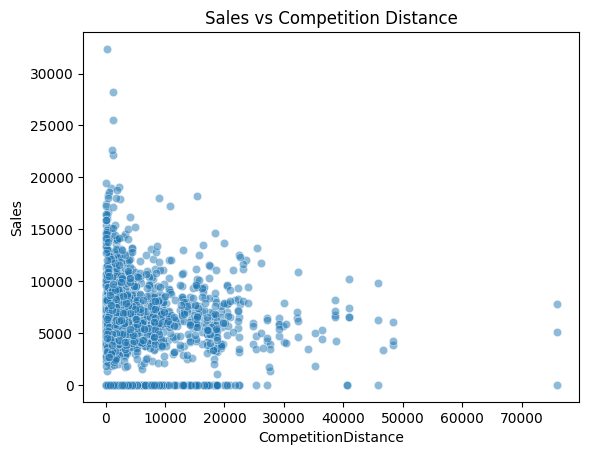

In [20]:
sns.scatterplot(data=df.sample(2000), x='CompetitionDistance', y='Sales', alpha=0.5)
plt.title('Sales vs Competition Distance')
plt.show()


In [48]:
# Filter one store (you can loop later)
store_id = 1
store_df = df[df['Store'] == store_id].sort_values('Date')
store_df = store_df[store_df['Open'] == 1][['Date', 'Sales', 'Promo']]
store_df.set_index('Date', inplace=True)


In [49]:
store_df.index = pd.to_datetime(store_df.index)


In [51]:
# Train-test split
train_data = store_df.iloc[:-60]   # all but last 60 days
test_data  = store_df.iloc[-60:]   # last 60 days for evaluation


In [52]:
model = SARIMAX(
    train_data['Sales'],
    exog=train_data[['Promo']],            # exogenous variable
    order=(1,1,1),
    seasonal_order=(1,1,1,7),              # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [57]:
# Prepare future exogenous data
future_exog = test_data[['Promo']]         # next 60 days (same shape as steps)


In [58]:
results.model.exog is not None


True

In [59]:
#Forecast next 60 days
forecast = results.get_forecast(steps=60, exog=future_exog)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [60]:
# Align forecast index

pred.index = test_data.index
conf_int.index = test_data.index

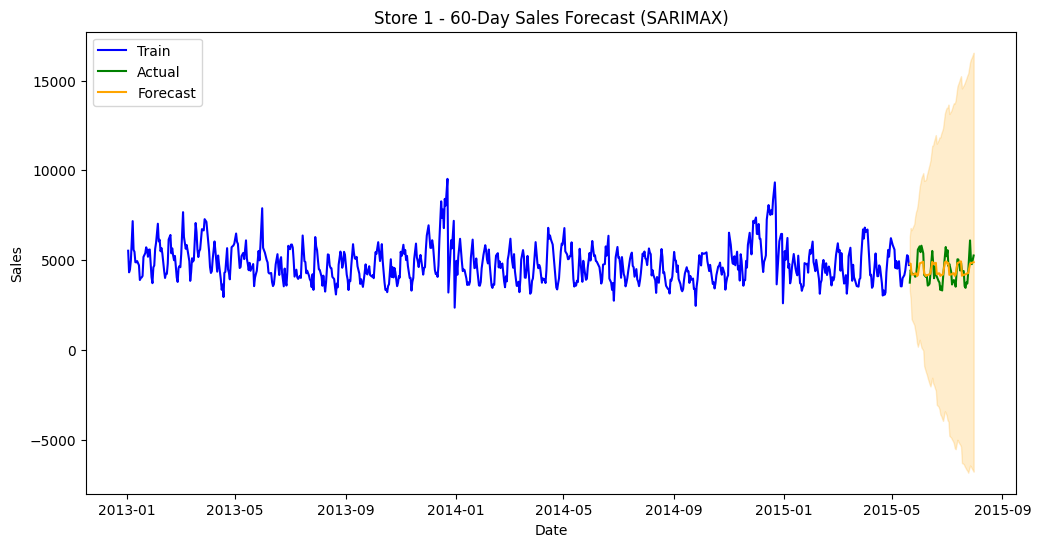

In [61]:
#Plot 
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Sales'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Sales'], label='Actual', color='green')
plt.plot(pred.index, pred, label='Forecast', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='orange', alpha=0.2)
plt.title(f"Store {store_id} - 60-Day Sales Forecast (SARIMAX)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [62]:
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_score = smape(test_data['Sales'], pred)
print(f"SMAPE: {smape_score:.2f}%")


SMAPE: 9.85%
